https://www.datacamp.com/community/tutorials/random-forests-classifier-python 

https://www.kaggle.com/patrickaudriaz/random-forests-for-multiclass-classification

https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook


## Load the data

In [5]:
data_train_path = 'C:/Users/manon/Desktop/Projet_2 _ML/code/datas/Split_Data_48_delay/Combined_All_Train_80_48_delay.csv'
data_test_path = 'C:/Users/manon/Desktop/Projet_2 _ML/code/datas/Split_Data_48_delay/Combined_All_Test_80_48_delay.csv'

tx_train = pd.read_csv(data_train_path,sep=",",squeeze=True)
X_train=tx_train.iloc[:, :48]
ytr = pd.read_csv(data_train_path,sep=",",usecols=[48],squeeze=True)

tx_test = pd.read_csv(data_test_path,sep=",",squeeze=True)
X_test=tx_test.iloc[:, :48]
yte = pd.read_csv(data_test_path,sep=",",usecols=[48],squeeze=True)

def add_column_names(data):
    
    liste=[]
    for i in range(48):
        liste.append(str(i+1))
    data.columns=liste
    return data,liste

X_train,liste = add_column_names(X_train)
X_test,liste = add_column_names(X_test)

ytr = ytr.astype(np.int64)
yte = yte.astype(np.int64)


In [6]:
print(X_train.shape)
print(ytr.shape)
print(X_test.shape)
print(yte.shape)

(8910, 48)
(8910,)
(2931, 48)
(2931,)


# Data Analysis

### Emotions represented in the training dataset

In [7]:
ytr = np.expand_dims(ytr, axis=1)
ytr = pd.DataFrame(ytr, columns = ['Emotions'])
yte = np.expand_dims(yte, axis=1)
yte = pd.DataFrame(yte, columns = ['Emotions'])
y=pd.concat([yte,ytr])

<AxesSubplot:xlabel='Emotions', ylabel='count'>

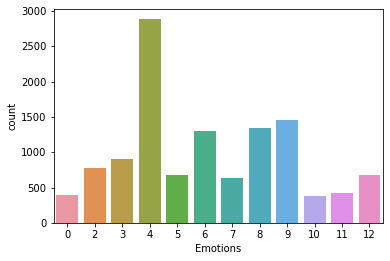

In [8]:
#from sklearn.preprocessing import LabelEncoder
def cm_to_inch(value):
    return value/2.54
categories = ['Anger','Sad','Guilt','Shame','Disgust','Anxiety','Fear','Surprise','Contempt','Satisfaction',
            'WarmHeartedness','Happiness', 'Love', 'Neutral' ]

fig , ax = plt.subplots(figsize=(cm_to_inch(15),cm_to_inch(10)))
sns.countplot(x='Emotions',data=y)

In [56]:

y_labels = inverse_transform(y)

ImportError: cannot import name 'inverse_transform' from 'sklearn.preprocessing' (C:\Users\manon\anaconda3\lib\site-packages\sklearn\preprocessing\__init__.py)

In [53]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
y=pd.concat([yte,ytr])
print(y.shape)
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

(14928,)
Class=8, n=2011 (13.471%)
Class=9, n=1610 (10.785%)
Class=10, n=557 (3.731%)
Class=3, n=1309 (8.769%)
Class=0, n=575 (3.852%)
Class=11, n=598 (4.006%)
Class=2, n=1045 (7.000%)
Class=5, n=922 (6.176%)
Class=6, n=1506 (10.088%)
Class=4, n=2993 (20.050%)
Class=12, n=840 (5.627%)
Class=7, n=962 (6.444%)


## Preprocessing

### Imbalanced classes 
SMOTE Oversampling : cf https://machinelearningmastery.com/multi-class-imbalanced-classification/ \
emotions are imbalanced : conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration

In [142]:
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, ytr = oversample.fit_resample(X_train, ytr)

### Data standardization

In [4]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x


In [5]:
Xtrain=standardize(X_train)
X_test=standardize(X_test)

### Correlation between features

Remove correlated features

In [84]:
corr = X_train.corr()
correlated_features=set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)

X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

C:\Users\manon\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [85]:
print(X_train.shape)
print(X_test.shape)

(8910, 33)
(2931, 33)


### Removing features with low variance

In [95]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.4)
sel.fit(X_train)
X_train = (pd.DataFrame(sel.transform(X_train)))
X_test = (pd.DataFrame(sel.transform(X_test)))

In [96]:
print(X_train.shape)
print(X_test.shape)

(8910, 32)
(2931, 32)


### Feature Scaling

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training

In [17]:
classifier = RandomForestClassifier(n_estimators = 500, criterion = 'gini', max_depth=9,random_state = 42)
classifier.fit(X_train, ytr)

RandomForestClassifier(max_depth=9, n_estimators=500, random_state=42)

In [18]:
# Predicting the Test set results
Y_pred = classifier.predict(X_test)

In [19]:
print(Y_pred)

[4 4 4 ... 6 6 6]


### Prediction of the model on the test set
Remark: Accuracy should be the same as the one just above

In [36]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(yte, Y_pred))

NameError: name 'Y_pred' is not defined

In [32]:
from sklearn import metrics
#yte = pd.DataFrame(yte, columns = ['Emotions'])
#print(yte.shape)
print(metrics.classification_report(yte, Y_pred))

              precision    recall  f1-score   support

           0       0.42      0.26      0.32       138
           2       0.71      0.02      0.04       259
           3       0.37      0.21      0.27       311
           4       0.30      0.69      0.41      1091
           5       0.75      0.10      0.17       219
           6       0.29      0.06      0.09       465
           7       0.68      0.10      0.18       222
           8       0.15      0.27      0.20       463
           9       0.35      0.17      0.23       517
          10       0.15      0.15      0.15       120
          11       0.71      0.04      0.07       130
          12       0.81      0.05      0.10       246

    accuracy                           0.28      4181
   macro avg       0.47      0.18      0.19      4181
weighted avg       0.40      0.28      0.23      4181



### Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 1, criterion='gini').fit(X_train, ytr)
dtree_predictions = dtree_model.predict(X_test)

In [37]:
print("Accuracy:",metrics.accuracy_score(yte, dtree_predictions))

Accuracy: 0.26524754843338916


In [38]:
error_rate=[]
for i in tqdm_notebook(range(1,50)):
    dtree_model = DecisionTreeClassifier(max_depth=i, criterion='gini')
    model = dtree_model.fit(X_train,ytr)
    pred_i = dtree_model.predict(X_test)
    error_rate.append(np.mean(pred_i != yte))
 

  0%|          | 0/49 [00:00<?, ?it/s]

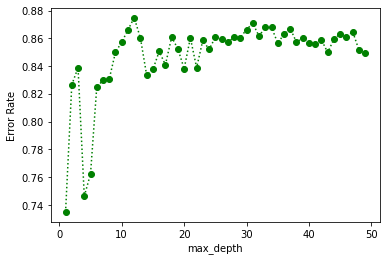

In [42]:
plt.figure(figsize=(cm_to_inch(15),cm_to_inch(10)))
plt.plot(range(1,50), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('max_depth')
plt.ylabel('Error Rate')
plt.show() 

### SVM

In [27]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 0.1).fit(X_train, ytr)
svm_predictions = svm_model_linear.predict(X_test)
 
# model accuracy for X_test 
accuracy = svm_model_linear.score(X_test, yte)
print("Accuracy:",accuracy)

Accuracy: 0.2111934943793351


In [30]:
Cs = np.linspace(0.01,1,200)
for c in tqdm_notebook(Cs):
    svm = SVC(kernel = 'linear', C = c)
    model = svm.fit(X_train,ytr)
    pred_i = svm.predict(X_test)
    error_rate.append(np.mean(pred_i != yte))


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 873, weights='distance').fit(X_train, ytr)
 
# accuracy on X_test
accuracy = knn.score(X_test, yte)
print("Accuracy:",accuracy)

Accuracy: 0.2697919158096149


In [14]:
error_rate=[]
for i in tqdm_notebook(range(500,1000)):
    knn = KNeighborsClassifier(n_neighbors=i)
    model = knn.fit(X_train,ytr)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != yte))
 

  0%|          | 0/500 [00:00<?, ?it/s]

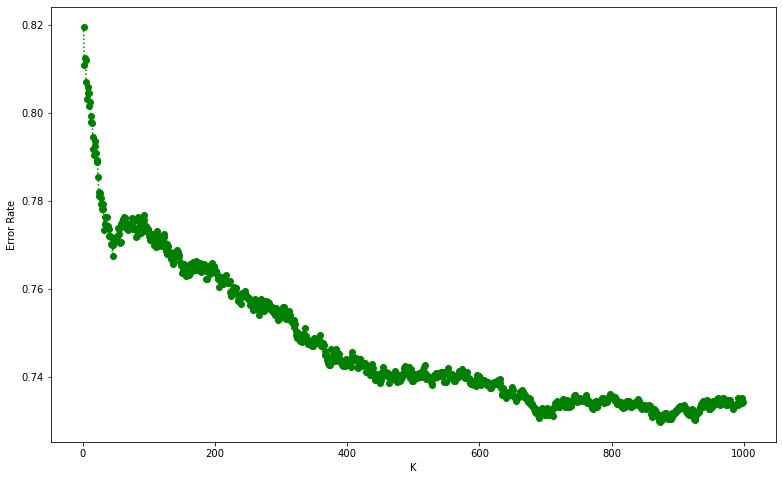

In [15]:
            
plt.figure(figsize=(13,8))
plt.plot(range(1,1000), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K')
plt.ylabel('Error Rate')
#plt.title('K value Vs Error Rate')
plt.show() 

In [17]:
print(np.argmin(error_rate))

873


### Gaussian Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,ytr)
#y_pred_test = gnb.predict(X_test)
accuracy = gnb.score(X_test, yte)
print("Accuracy:",accuracy)

Accuracy: 0.05285816790241569


### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'saga',multi_class='auto')
logreg.fit(X_train,ytr)
accuracy = logreg.score(X_test, yte)
print("Accuracy:",accuracy)

Accuracy: 0.22052140636211431


C:\Users\manon\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### RandomForest : Hyperparameter tuning using grid search and cross validation

https://www.kaggle.com/patrickaudriaz/random-forests-for-multiclass-classification

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto',  'log2'],
    'max_depth' : [3,5,7,9],
    'criterion' :['gini', 'entropy']
}


CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, ytr)

print("Best hyperparameters --> \n", CV_rfc.best_params_)

KeyboardInterrupt: 

## Confusion matrix

In [102]:
from sklearn.metrics import confusion_matrix
lbs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
cf_matrix = confusion_matrix(yte, Y_pred,labels=lbs)
#print(cf_matrix)

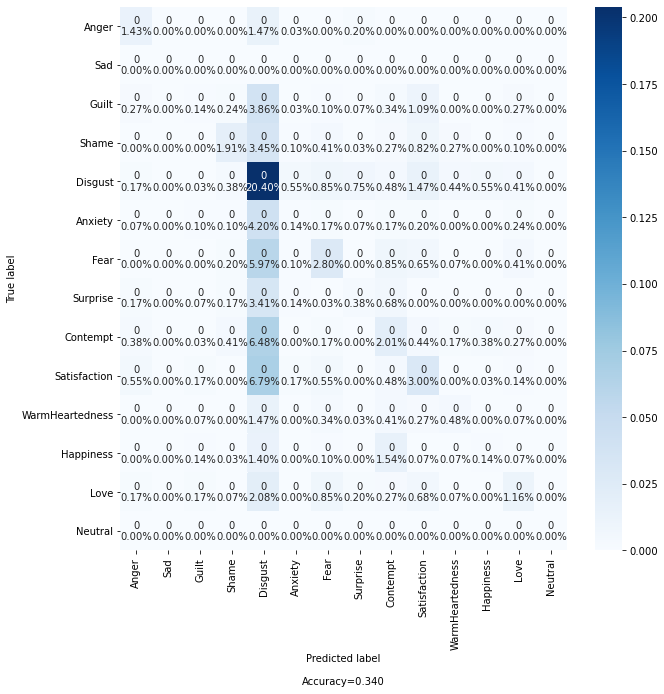

In [103]:
import seaborn as sns
from cf_matrix import make_confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

categories = ['Anger','Sad','Guilt','Shame','Disgust','Anxiety','Fear','Surprise','Contempt','Satisfaction',
            'WarmHeartedness','Happiness', 'Love', 'Neutral' ]
make_confusion_matrix(cf_matrix/np.sum(cf_matrix),
             categories=categories, cmap='Blues')

In [36]:
print(((y_pred==0).sum())/y_pred.shape[0])

0.9808658215737862


In [132]:
print((yte==4).sum())

1091


In [15]:
print(cf_matrix.sum())

4393


# Feature importance

In [62]:
feature_imp = pd.Series(classifier.feature_importances_,index=liste).sort_values(ascending=False)
#feature_imp

10    0.045262
9     0.037688
35    0.033619
39    0.030157
45    0.027118
48    0.026708
40    0.025957
46    0.025449
23    0.023933
24    0.023917
18    0.023646
8     0.023589
43    0.023212
19    0.022760
27    0.022511
36    0.021441
32    0.021398
6     0.020377
33    0.020270
11    0.019884
12    0.019681
44    0.019622
14    0.019597
29    0.019184
25    0.018836
37    0.018822
21    0.018791
31    0.018697
5     0.018598
16    0.018403
38    0.018386
47    0.018272
13    0.017886
20    0.017446
22    0.017124
15    0.016999
1     0.016639
42    0.016493
28    0.016238
3     0.015891
17    0.015634
41    0.015558
26    0.015304
7     0.015285
34    0.014851
4     0.014732
2     0.014235
30    0.013900
dtype: float64

No handles with labels found to put in legend.


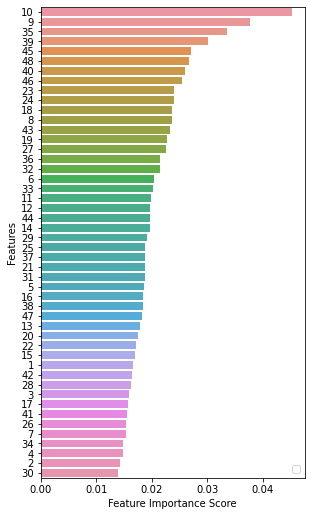

In [66]:
%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(cm_to_inch(12),cm_to_inch(22)))
sns.barplot(x=feature_imp[:48], y=feature_imp.index[:48])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()

# Storing the trained model

In [71]:
from sklearn.externals import joblib
joblib.dump(classifier, 'randomforestmodel.pkl') 

ImportError: cannot import name 'joblib' from 'sklearn.externals' (C:\Users\manon\anaconda3\lib\site-packages\sklearn\externals\__init__.py)